# Agent Based Modelling

Sidney Bush 

This model simulates tree death as a result of beetle infestations. Tree cells can exist in three states: alive, infested and dead, with infested trees more prone to tree death. Soil moisture was also added as an agent, but was not used in the final model. Trees can either be dry, wet or average, with dry trees more prone to tree death than average or wet trees. These two variables are also related - a tree that is infested by beetles and is also dry is more prone to dying than an infested tree that still has average or above average moisture. Though these variables do not interact in this model, this is something that could be easily added (with better Python skills) to increase the accuracy of this model. Tree density is first manipulated to simulate tree death in each cell. Finally, a model including tree infestation, death and recovery is animated to demonstrate the impact of beetle infestations on a given cell of trees over time. 

In [1]:
# Import packages etc. 

import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [2]:
# Create Beetle Kill Model 

class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Alive", "Infested", or "Dead"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Alive"
        
    def step(self):
        '''
        If the tree is infested, spread it to alive trees nearby.
        '''
        if self.condition == "Infested":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Alive":
                    neighbor.condition = "Infested"
            self.condition = "Dead"
            
# Want to add in other factors that impact tree death - Tree is more susceptible to death if it is dry 
## Tree Cell can be wet, dry or average.

### This ended up not being added to the model, though adding how moisture interacts with beetle infestation and 
### tree death would increase the complexity of my model
class TreeMoisture(Agent):
    '''
    Moisture of Tree.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Wet","Dry"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create moisture in cell.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Wet"
        
    def step(self):
        '''
        If the tree is dry, spread it to wet trees nearby.
        '''
        if self.condition == "Average":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Wet":
                    neighbor.condition = "Average"
            self.condition = "Dry"
      

In [3]:
# Create model of beetle kill which includes trees that are alive, infested, or dead.
class BeetleKill(Model):
    '''
    Simple Beetle Kill model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Alive": lambda m: self.count_type(m, "Alive"),
                                "Infested": lambda m: self.count_type(m, "Infested"),
                                "Dead": lambda m: self.count_type(m, "Dead")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column Infested.
                    if x == 0:
                        new_tree.condition = "Infested"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more beetle infestation 
        if self.count_type(self, "Infested") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

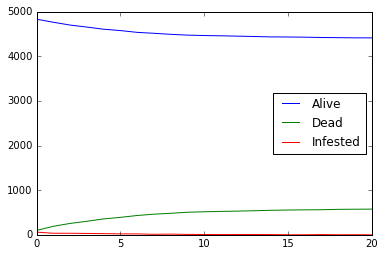

In [4]:
# Test a medium range tree density - 50%
beetle = BeetleKill(100, 100, 0.5)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

With a medium range tree density, the number of trees that are alive take an initial dip, but remain steady, the number of trees that are infested decreases, and the number of dead trees increases. This makes sense because as trees become infested, they are dying, reducing the number of trees that are alive.  

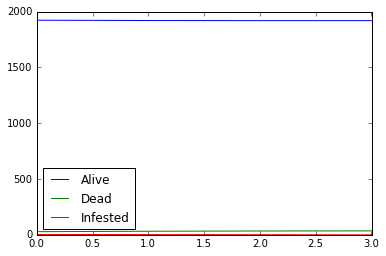

In [5]:
# Test the impact of more sparse tree density - 20% tree cover
beetle = BeetleKill(100, 100, 0.2)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

With a very sparse tree cell, the number of trees in each category remains the same, which is to be expected since trees are less likely to be neighbors in a low density tree cell. Thus infestation would not spread, and tree death would not increase or decrease. 

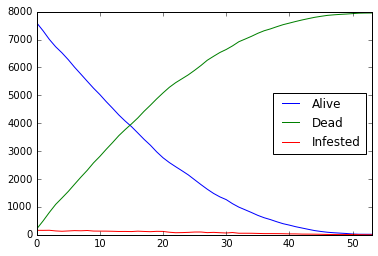

In [19]:
# Test the impact of higher tree density - 80% tree cover
beetle = BeetleKill(100, 100, 0.8)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

On the other hand, a relatively high density tree cell (80%) yields widely different results. The number infested trees decreases slowly over time, while trees die drastically. This makes sense because higher density increases proximity of trees to infested trees, increasing the likelihood of the spread of infestation. 

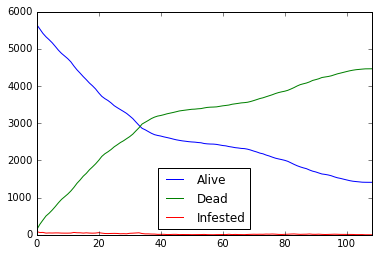

In [21]:
# Test the impact of slightly above half tree density - 60% tree cover, this amount of tree death seems a little drastic
beetle = BeetleKill(100, 100, 0.6)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

With a density slightly above half (60%), infested trees remains relatively steady, only decreasing slightly over time. Tree death increases at a drastic rate and then begins to level off. 

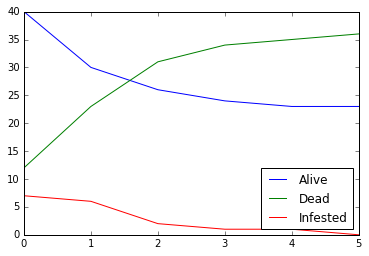

In [22]:
# Test the impact of slightly above half tree density - 60% tree cover
# Lets also see what happens when we decrease the grid size
beetle = BeetleKill(10, 10, 0.6)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

Changing the grid size yields different results, even when density is kept constant - infested trees decreases in steps, rather than gradually over time. The rate of tree death is lower, though a greater portion of trees die. 

In [8]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])    

In [9]:
# At the end of each model run, calculate the fraction of trees which are Dead
model_reporter = {"Dead": lambda m: (BeetleKill.count_type(m, "Dead") / 
                                          m.schedule.get_agent_count()) }

In [10]:
# Create the batch runner
param_run = BatchRunner(BeetleKill, param_set, model_reporters=model_reporter)

In [11]:
param_run.run_all()

100%|██████████| 100/100 [00:10<00:00,  2.97it/s]


In [12]:

df = param_run.get_model_vars_dataframe()

In [13]:
df.head()

,Dead,Run,density,height,width
0,0.978408,63,0.64,50,50
1,0.999548,86,0.87,50,50
2,0.418729,58,0.59,50,50
3,0.997596,81,0.82,50,50
4,0.054054,30,0.31,50,50


(0, 1)

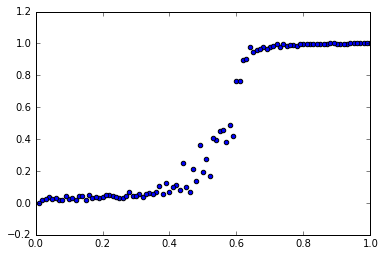

In [14]:
plt.scatter(df.density, df.Dead)
plt.xlim(0,1)

100%|██████████| 500/500 [00:57<00:00,  4.57it/s]


(0, 1)

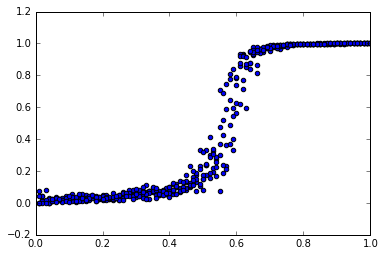

In [15]:
param_run = BatchRunner(BeetleKill, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.Dead)
plt.xlim(0,1)

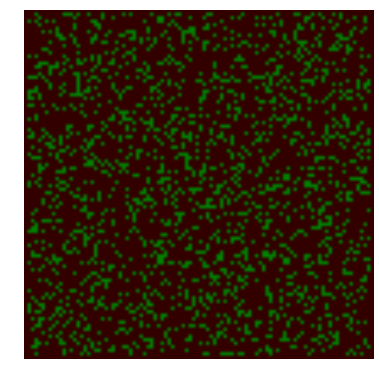

In [42]:
# Try to make a cool animation of beetle kill: 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc, animation
rc('animation', html='html5')

# Displacements from a cell to its eight nearest neighbours
neighbourhood = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
Dead, Alive, Infested = 0, 1, 2

# Colours for visualization: brown for EMPTY, dark green for TREE and orange for BEETLE KILL. 
# Note that for the colormap to work, this list and the bounds list must be one larger than the number of 
# different values in the array.
colors_list = [(0.2,0,0), (0,0.5,0), (1,0,0), 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

def iterate(beetle):
    """Iterate the forest according to the beetle kill rules."""

    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    X1 = np.zeros((ny, nx))
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            if X[iy,ix] == Dead and np.random.random() <= p:
                X1[iy,ix] = Alive
            if X[iy,ix] == Alive:
                X1[iy,ix] = Alive
                for dx,dy in neighbourhood:
                    if X[iy+dy,ix+dx] == Infested:
                        X1[iy,ix] = Infested
                        break
                else:
                    if np.random.random() <= f:
                        X1[iy,ix] = Infested
    return X1

# The initial fraction of the forest occupied by trees.
# Set this at 0.2 so that the effect is easier to notice
forest_fraction = 0.2

# Probability of new tree growth per empty cell, and of beetle infestation.
# Tree growth is low, since trees infested by beetles will not 
# grow back and trees not infested would regrow at a very slow rate
# Beetle kill is much higher, since if infested, trees are likely to die

p, f = 0.00001, 0.5

# Forest size (number of cells in x and y directions).
# Same as our previous simulation - there are large forests in CO
nx, ny = 100, 100

# Initialize the forest grid.
X  = np.zeros((ny, nx))
X[1:ny-1, 1:nx-1] = np.random.randint(0, 2, size=(ny-2, nx-2))
X[1:ny-1, 1:nx-1] = np.random.random(size=(ny-2, nx-2)) < forest_fraction

fig = plt.figure(figsize=(25/3, 6.25))
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(X, cmap=cmap, norm=norm)#, interpolation='nearest')

# The animation function: called to produce a frame for each generation.
def animate(i):
    im.set_data(animate.X)
    animate.X = iterate(animate.X)
    
# Bind our grid to the identifier X in the animate function's namespace.
animate.X = X

# Interval between frames (ms).
interval = 100
anim = animation.FuncAnimation(fig, animate, interval=interval)
plt.show()

In [43]:
# Uploaded to repo: 
anim.save("test.mp4") 

As seen in this animation, beetle kill becomes widespread once infestation occurs. This is observed in forests that are seeing high rates of beetle infestation in the Rocky Mountiains, especially in the Canadian Rockies. 

Source for animation code: http://scipython.com/blog/the-forest-fire-model/ 